# ReconstructingRegressor
# Only 1


**Chapter 12 – Custom Models and Training with TensorFlow**

_This notebook contains all the sample code in chapter 12._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/12_custom_models_and_training_with_tensorflow.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import tensorflow as tf
print(tf.__version__)

2.3.0


First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [4]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# try:
#     # %tensorflow_version only exists in Colab.
#     %tensorflow_version 2.x
# except Exception:
#     pass

# # TensorFlow ≥2.0 is required
# import tensorflow as tf
from tensorflow import keras
# assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Tensors and operations

### Tensors

In [5]:
tf.constant([[1., 2., 3.], [4., 5., 6.]]) # matrix

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [6]:
tf.constant(42) # scalar

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [7]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [8]:
t.shape

TensorShape([2, 3])

In [9]:
t.dtype

tf.float32

### Indexing

In [10]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [11]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

### Ops

In [12]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [13]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [14]:
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

### Using `keras.backend`

In [15]:
from tensorflow import keras
K = keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

### From/To NumPy

In [16]:
a = np.array([2., 4., 5.])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [17]:
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [18]:
np.array(t)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [19]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [20]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

### Conflicting Types

In [21]:
try:
    tf.constant(2.0) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2]


In [22]:
try:
    tf.constant(2.0) + tf.constant(40., dtype=tf.float64)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2]


In [23]:
t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

### Strings

In [24]:
tf.constant(b"hello world")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world'>

In [25]:
tf.constant("café")

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [26]:
u = tf.constant([ord(c) for c in "café"])
u

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

In [27]:
b = tf.strings.unicode_encode(u, "UTF-8")
tf.strings.length(b, unit="UTF8_CHAR")

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [28]:
tf.strings.unicode_decode(b, "UTF-8")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

### String arrays

In [29]:
p = tf.constant(["Café", "Coffee", "caffè", "咖啡"])

In [30]:
tf.strings.length(p, unit="UTF8_CHAR")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([4, 6, 5, 2], dtype=int32)>

In [31]:
r = tf.strings.unicode_decode(p, "UTF8")
r

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857]]>

In [32]:
print(r)

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857]]>


### Ragged tensors

In [33]:
print(r[1])

tf.Tensor([ 67 111 102 102 101 101], shape=(6,), dtype=int32)


In [34]:
print(r[1:3])

<tf.RaggedTensor [[67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232]]>


In [35]:
r2 = tf.ragged.constant([[65, 66], [], [67]])
print(tf.concat([r, r2], axis=0))

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857], [65, 66], [], [67]]>


In [36]:
r3 = tf.ragged.constant([[68, 69, 70], [71], [], [72, 73]])
print(tf.concat([r, r3], axis=1))

<tf.RaggedTensor [[67, 97, 102, 233, 68, 69, 70], [67, 111, 102, 102, 101, 101, 71], [99, 97, 102, 102, 232], [21654, 21857, 72, 73]]>


In [37]:
tf.strings.unicode_encode(r3, "UTF-8")

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'DEF', b'G', b'', b'HI'], dtype=object)>

In [38]:
r.to_tensor()

<tf.Tensor: shape=(4, 6), dtype=int32, numpy=
array([[   67,    97,   102,   233,     0,     0],
       [   67,   111,   102,   102,   101,   101],
       [   99,    97,   102,   102,   232,     0],
       [21654, 21857,     0,     0,     0,     0]], dtype=int32)>

### Sparse tensors

In [39]:
s = tf.SparseTensor(indices=[[0, 1], [1, 0], [2, 3]],
                    values=[1., 2., 3.],
                    dense_shape=[3, 4])

In [40]:
print(s)

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [41]:
tf.sparse.to_dense(s)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [2., 0., 0., 0.],
       [0., 0., 0., 3.]], dtype=float32)>

In [42]:
s2 = s * 2.0

In [43]:
try:
    s3 = s + 1.
except TypeError as ex:
    print(ex)

unsupported operand type(s) for +: 'SparseTensor' and 'float'


In [44]:
s4 = tf.constant([[10., 20.], [30., 40.], [50., 60.], [70., 80.]])
tf.sparse.sparse_dense_matmul(s, s4)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 30.,  40.],
       [ 20.,  40.],
       [210., 240.]], dtype=float32)>

In [45]:
s5 = tf.SparseTensor(indices=[[0, 2], [0, 1]],
                     values=[1., 2.],
                     dense_shape=[3, 4])
print(s5)

SparseTensor(indices=tf.Tensor(
[[0 2]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([1. 2.], shape=(2,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [46]:
try:
    tf.sparse.to_dense(s5)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

indices[1] = [0,1] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SparseToDense]


In [47]:
s6 = tf.sparse.reorder(s5)
tf.sparse.to_dense(s6)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 2., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

### Sets

In [48]:
set1 = tf.constant([[2, 3, 5, 7], [7, 9, 0, 0]])
set2 = tf.constant([[4, 5, 6], [9, 10, 0]])
tf.sparse.to_dense(tf.sets.union(set1, set2))

<tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 2,  3,  4,  5,  6,  7],
       [ 0,  7,  9, 10,  0,  0]], dtype=int32)>

In [49]:
tf.sparse.to_dense(tf.sets.difference(set1, set2))

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[2, 3, 7],
       [7, 0, 0]], dtype=int32)>

In [50]:
tf.sparse.to_dense(tf.sets.intersection(set1, set2))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[5, 0],
       [0, 9]], dtype=int32)>

### Variables

In [51]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])

In [52]:
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [53]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [54]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [55]:
try:
    v[1] = [7., 8., 9.]
except TypeError as ex:
    print(ex)

'ResourceVariable' object does not support item assignment


In [56]:
v.scatter_nd_update(indices=[[0, 0], [1, 2]],
                    updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

In [57]:
sparse_delta = tf.IndexedSlices(values=[[1., 2., 3.], [4., 5., 6.]],
                                indices=[1, 0])
v.scatter_update(sparse_delta)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[4., 5., 6.],
       [1., 2., 3.]], dtype=float32)>

### Tensor Arrays

In [58]:
array = tf.TensorArray(dtype=tf.float32, size=3)
array = array.write(0, tf.constant([1., 2.]))
array = array.write(1, tf.constant([3., 10.]))
array = array.write(2, tf.constant([5., 7.]))

In [59]:
array.read(1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 3., 10.], dtype=float32)>

In [60]:
array.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [0., 0.],
       [5., 7.]], dtype=float32)>

In [61]:
mean, variance = tf.nn.moments(array.stack(), axes=0)
mean

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 3.], dtype=float32)>

In [62]:
variance

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.6666665, 8.666667 ], dtype=float32)>

## Custom loss function

Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set, and finally we scale it:

In [63]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [64]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

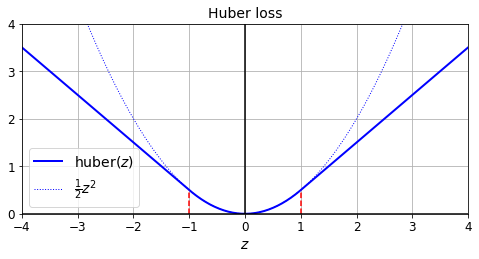

In [65]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [66]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [67]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [68]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.6235 - mae: 0.9953 - val_loss: 0.2862 - val_mae: 0.5866
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2197 - mae: 0.5177 - val_loss: 0.2382 - val_mae: 0.5281


## Saving/Loading Models with Custom Objects

In [69]:
model.save("output/custom/my_model_with_a_custom_loss.h5")

In [70]:
model = keras.models.load_model("output/custom/my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})

In [71]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2054 - mean_absolute_error: 0.4982 - val_loss: 0.2209 - val_mean_absolute_error: 0.5050
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1999 - mean_absolute_error: 0.4900 - val_loss: 0.2127 - val_mean_absolute_error: 0.4986


In [72]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [73]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [74]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2226 - mae: 0.4892 - val_loss: 0.2540 - val_mae: 0.4907
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2184 - mae: 0.4844 - val_loss: 0.2372 - val_mae: 0.4879


In [75]:
model.save("output/custom/my_model_with_a_custom_loss_threshold_2.h5")

In [76]:
model = keras.models.load_model("output/custom/my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

In [77]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2147 - mean_absolute_error: 0.4800 - val_loss: 0.2133 - val_mean_absolute_error: 0.4654
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2119 - mean_absolute_error: 0.4762 - val_loss: 0.1992 - val_mean_absolute_error: 0.4643


In [78]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [79]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [80]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [81]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.7095 - mae: 0.8863 - val_loss: 0.3378 - val_mae: 0.5485
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2416 - mae: 0.5083 - val_loss: 0.2660 - val_mae: 0.5089


In [82]:
model.save("output/custom/my_model_with_a_custom_loss_class.h5")

In [83]:
#model = keras.models.load_model("my_model_with_a_custom_loss_class.h5", # TODO: check PR #25956
#                                custom_objects={"HuberLoss": HuberLoss})

In [84]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2286 - mae: 0.4970 - val_loss: 0.2120 - val_mae: 0.4723
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2216 - mae: 0.4904 - val_loss: 0.2045 - val_mae: 0.4725


In [85]:
#model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",  # TODO: check PR #25956
#                                custom_objects={"HuberLoss": HuberLoss})

In [86]:
model.loss.threshold

2.0

## Other Custom Functions

In [87]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [88]:
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [89]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [90]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [91]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [92]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [93]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 1.5542 - mae: 0.8962 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.5943 - mae: 0.5256 - val_loss: 1.4399 - val_mae: 0.5137


In [94]:
model.save("output/custom/my_model_with_many_custom_parts.h5")

In [95]:
model = keras.models.load_model(
    "output/custom/my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

In [96]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

In [97]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [98]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [99]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [100]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 1.5542 - mae: 0.8962 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.5943 - mae: 0.5256 - val_loss: 1.4399 - val_mae: 0.5137


In [101]:
model.save("output/custom/my_model_with_many_custom_parts.h5")

In [102]:
model = keras.models.load_model(
    "output/custom/my_model_with_many_custom_parts.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

## Custom Metrics

In [103]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [104]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [105]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [106]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 2.0982 - huber_fn: 0.9192
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.6052 - huber_fn: 0.2733


**Warning**: if you use the same function as the loss and a metric, you may be surprised to see different results. This is generally just due to floating point precision errors: even though the mathematical equations are equivalent, the operations are not run in the same order, which can lead to small differences. Moreover, when using sample weights, there's more than just precision errors:
* the loss since the start of the epoch is the mean of all batch losses seen so far. Each batch loss is the sum of the weighted instance losses divided by the _batch size_ (not the sum of weights, so the batch loss is _not_ the weighted mean of the losses).
* the metric since the start of the epoch is equal to the sum of weighted instance losses divided by sum of all weights seen so far. In other words, it is the weighted mean of all the instance losses. Not the same thing.

If you do the math, you will find that loss = metric * mean of sample weights (plus some floating point precision error).

In [107]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])

In [108]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1175 - huber_fn: 0.2399
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1131 - huber_fn: 0.2297


In [109]:
history.history["loss"][0], history.history["huber_fn"][0] * sample_weight.mean()

(0.11749907582998276, 0.11906624094207695)

### Streaming metrics

In [110]:
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [111]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [112]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [113]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [114]:
precision.reset_states()

Creating a streaming metric:

In [115]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        #self.huber_fn = create_huber(threshold) # TODO: investigate why this fails
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def huber_fn(self, y_true, y_pred): # workaround
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

**Warning**: when running the following cell, if you get autograph warnings such as `WARNING:tensorflow:AutoGraph could not transform [...] and will run it as-is`, then please install version 0.2.2 of the gast library (e.g., by running `!pip install gast==0.2.2`), then restart the kernel and run this notebook again from the beginning (see [autograph issue #1](https://github.com/tensorflow/autograph/issues/1) for more details):

In [116]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]])) 

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [117]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [118]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [119]:
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

Let's check that the `HuberMetric` class works well:

In [120]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [121]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [122]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])

In [123]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.8707 - huber_metric: 0.8707
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2595 - huber_metric: 0.2595


In [124]:
model.save("output/custom/my_model_with_a_custom_metric.h5")

In [125]:
#model = keras.models.load_model("my_model_with_a_custom_metric.h5",           # TODO: check PR #25956
#                                custom_objects={"huber_fn": create_huber(2.0),
#                                                "HuberMetric": HuberMetric})

In [126]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2350 - huber_metric: 0.2350
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2278 - huber_metric: 0.2278


**Warning**: In TF 2.2, tf.keras adds an extra first metric in `model.metrics` at position 0 (see [TF issue #38150](https://github.com/tensorflow/tensorflow/issues/38150)). This forces us to use `model.metrics[-1]` rather than `model.metrics[0]` to access the `HuberMetric`.

In [127]:
model.metrics[-1].threshold

2.0

Looks like it works fine! More simply, we could have created the class like this:

In [128]:
class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}        

This class handles shapes better, and it also supports sample weights.

In [129]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [130]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [131]:
model.compile(loss=keras.losses.Huber(2.0), optimizer="nadam", weighted_metrics=[HuberMetric(2.0)])

In [132]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32),
                    epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.4455 - HuberMetric: 0.8978
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1305 - HuberMetric: 0.2631


In [133]:
history.history["loss"][0], history.history["HuberMetric"][0] * sample_weight.mean()

(0.44554364681243896, 0.44554368685750223)

In [134]:
model.save("output/custom/my_model_with_a_custom_metric_v2.h5")

In [135]:
#model = keras.models.load_model("my_model_with_a_custom_metric_v2.h5",        # TODO: check PR #25956
#                                custom_objects={"HuberMetric": HuberMetric})

In [136]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2377 - HuberMetric: 0.2377
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2279 - HuberMetric: 0.2279


**Warning**: In TF 2.2, tf.keras adds an extra first metric in `model.metrics` at position 0 (see [TF issue #38150](https://github.com/tensorflow/tensorflow/issues/38150)). This forces us to use `model.metrics[-1]` rather than `model.metrics[0]` to access the `HuberMetric`.

In [137]:
model.metrics[-1].threshold

2.0

## Custom Layers

In [138]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [139]:
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787948, 1.        , 2.7182817 ], dtype=float32)>

Adding an exponential layer at the output of a regression model can be useful if the values to predict are positive and with very different scales (e.g., 0.001, 10., 10000):

In [140]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [141]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 6191386483228672.0000 - val_loss: inf
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 1525441789689856.0000 - val_loss: inf
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 997166919188480.0000 - val_loss: inf
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 15270471008256.0000 - val_loss: inf
Epoch 5/5
162/162 [==============================] - 0s 775us/step - loss: 125075.5703


125075.5703125

In [142]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

In [143]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [144]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

In [145]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 2.2563 - val_loss: 0.9472
Epoch 2/2
162/162 [==============================] - 0s 866us/step - loss: 0.5474


0.5473727583885193

In [146]:
model.save("output/custom/my_model_with_a_custom_layer.h5")

In [147]:
model = keras.models.load_model("output/custom/my_model_with_a_custom_layer.h5",
                                custom_objects={"MyDense": MyDense})

In [148]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

In [149]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [150]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

Let's create a layer with a different behavior during training and testing:

In [151]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [152]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.4904 - val_loss: 0.5329
Epoch 2/2
162/162 [==============================] - 0s 859us/step - loss: 0.3990


0.39900389313697815

## Custom Models

In [153]:
X_new_scaled = X_test_scaled

In [154]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [155]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [156]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [157]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 1s 3ms/step - loss: 9.1324
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 1.0580
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.8869
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5835
Epoch 5/5
162/162 [==============================] - 0s 1ms/step - loss: 0.6500


In [158]:
model.save("output/custom/my_custom_model.ckpt")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: output/custom/my_custom_model.ckpt/assets


In [159]:
model = keras.models.load_model("output/custom/my_custom_model.ckpt")

In [160]:
history = model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 1s 3ms/step - loss: 0.7994
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5274
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4464
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4898
Epoch 5/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5097


We could have defined the model using the sequential API instead:

In [161]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [162]:
block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

In [163]:
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 0.8695
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4720
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5537
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3809
Epoch 5/5
162/162 [==============================] - 0s 1ms/step - loss: 0.4852


## Losses and Metrics Based on Model Internals

In [164]:
class ReconstructingRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        # TODO: check https://github.com/tensorflow/tensorflow/issues/26260
        #self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        #if training:
        #    result = self.reconstruction_mean(recon_loss)
        #    self.add_metric(result)
        return self.out(Z)

In [165]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [166]:
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)

Epoch 1/2


InaccessibleTensorError: in user code:

    /usr/lib/python3/dist-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /usr/lib/python3/dist-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/lib/python3/dist-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/lib/python3/dist-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/lib/python3/dist-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/lib/python3/dist-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /usr/lib/python3/dist-packages/tensorflow/python/keras/engine/training.py:748 train_step
        loss = self.compiled_loss(
    /usr/lib/python3/dist-packages/tensorflow/python/keras/engine/compile_utils.py:230 __call__
        reg_loss = math_ops.add_n(regularization_losses)
    /usr/lib/python3/dist-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/lib/python3/dist-packages/tensorflow/python/ops/math_ops.py:3512 add_n
        return gen_math_ops.add_n(inputs, name=name)
    /usr/lib/python3/dist-packages/tensorflow/python/ops/gen_math_ops.py:431 add_n
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /usr/lib/python3/dist-packages/tensorflow/python/framework/op_def_library.py:742 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /usr/lib/python3/dist-packages/tensorflow/python/framework/func_graph.py:589 _create_op_internal
        inp = self.capture(inp)
    /usr/lib/python3/dist-packages/tensorflow/python/framework/func_graph.py:634 capture
        raise errors.InaccessibleTensorError(

    InaccessibleTensorError: The tensor 'Tensor("mul:0", shape=(), dtype=float32)' cannot be accessed here: it is defined in another function or code block. Use return values, explicit Python locals or TensorFlow collections to access it. Defined in: FuncGraph(name=build_graph, id=139765893836128); accessed from: FuncGraph(name=train_function, id=139765893592304).
    


## Computing Gradients with Autodiff

In [167]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [168]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [169]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

In [170]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

In [171]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [172]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
try:
    dz_dw2 = tape.gradient(z, w2)
except RuntimeError as ex:
    print(ex)

GradientTape.gradient can only be called once on non-persistent tapes.


In [173]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2) # works now!
del tape

In [174]:
dz_dw1, dz_dw2

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

In [175]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [176]:
gradients

[None, None]

In [177]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [178]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [179]:
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [180]:
with tf.GradientTape(persistent=True) as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tf.reduce_sum(tf.stack([tape.gradient(z, [w1, w2]) for z in (z1, z2, z3)]), axis=0)
del tape

In [181]:
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [182]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [183]:
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

In [184]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

In [185]:
x = tf.Variable(100.)
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=nan>]

In [186]:
tf.math.log(tf.exp(tf.constant(30., dtype=tf.float32)) + 1.)

<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

In [187]:
x = tf.Variable([100.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

In [188]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

In [189]:
def my_better_softplus(z):
    return tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))

In [190]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>])

# Computing Gradients Using Autodiff

In [191]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [192]:
l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [193]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [194]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)

In [195]:
import time

mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 - loss: 0.0900 - mean_square: 858.5000


A fancier version with a progress bar:

In [196]:
def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

In [197]:
progress_bar(3500, 10000, size=6)

' 3500/10000 [=>....]'

In [198]:
def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)

In [199]:
mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 [==============================] - loss: 0.0900 - mean_square: 858.5000


In [200]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [201]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

In [202]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11610/11610 [==============================] - mean: 1.3955 - mean_absolute_error: 0.5722
Epoch 2/5
11610/11610 [==============================] - mean: 0.6774 - mean_absolute_error: 0.5280
Epoch 3/5
11610/11610 [==============================] - mean: 0.6351 - mean_absolute_error: 0.5177
Epoch 4/5
11610/11610 [==============================] - mean: 0.6384 - mean_absolute_error: 0.5181
Epoch 5/5
11610/11610 [==============================] - mean: 0.6440 - mean_absolute_error: 0.5222


In [203]:
try:
    from tqdm.notebook import trange
    from collections import OrderedDict
    with trange(1, n_epochs + 1, desc="All epochs") as epochs:
        for epoch in epochs:
            with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
                for step in steps:
                    X_batch, y_batch = random_batch(X_train_scaled, y_train)
                    with tf.GradientTape() as tape:
                        y_pred = model(X_batch)
                        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                        loss = tf.add_n([main_loss] + model.losses)
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    for variable in model.variables:
                        if variable.constraint is not None:
                            variable.assign(variable.constraint(variable))                    
                    status = OrderedDict()
                    mean_loss(loss)
                    status["loss"] = mean_loss.result().numpy()
                    for metric in metrics:
                        metric(y_batch, y_pred)
                        status[metric.name] = metric.result().numpy()
                    steps.set_postfix(status)
            for metric in [mean_loss] + metrics:
                metric.reset_states()
except ImportError as ex:
    print("To run this cell, please install tqdm, ipywidgets and restart Jupyter")

To run this cell, please install tqdm, ipywidgets and restart Jupyter


## TensorFlow Functions

In [204]:
def cube(x):
    return x ** 3

In [205]:
cube(2)

8

In [206]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [207]:
tf_cube = tf.function(cube)
tf_cube

In [208]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [209]:
tf_cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

### TF Functions and Concrete Functions

In [210]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))
concrete_function.graph

In [211]:
concrete_function(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [212]:
concrete_function is tf_cube.get_concrete_function(tf.constant(2.0))

True

### Exploring Function Definitions and Graphs

In [213]:
concrete_function.graph

In [214]:
ops = concrete_function.graph.get_operations()
ops

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [215]:
pow_op = ops[2]
list(pow_op.inputs)

[<tf.Tensor 'x:0' shape=() dtype=float32>,
 <tf.Tensor 'pow/y:0' shape=() dtype=float32>]

In [216]:
pow_op.outputs

[<tf.Tensor 'pow:0' shape=() dtype=float32>]

In [217]:
concrete_function.graph.get_operation_by_name('x')

<tf.Operation 'x' type=Placeholder>

In [218]:
concrete_function.graph.get_tensor_by_name('Identity:0')

<tf.Tensor 'Identity:0' shape=() dtype=float32>

In [219]:
concrete_function.function_def.signature

name: "__inference_cube_601998"
input_arg {
  name: "x"
  type: DT_FLOAT
}
output_arg {
  name: "identity"
  type: DT_FLOAT
}

### How TF Functions Trace Python Functions to Extract Their Computation Graphs

In [220]:
@tf.function
def tf_cube(x):
    print("print:", x)
    return x ** 3

In [221]:
result = tf_cube(tf.constant(2.0))

print: Tensor("x:0", shape=(), dtype=float32)


In [222]:
result

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [223]:
result = tf_cube(2)
result = tf_cube(3)
result = tf_cube(tf.constant([[1., 2.]])) # New shape: trace!
result = tf_cube(tf.constant([[3., 4.], [5., 6.]])) # New shape: trace!
result = tf_cube(tf.constant([[7., 8.], [9., 10.], [11., 12.]])) # no trace

print: 2
print: 3
print: Tensor("x:0", shape=(1, 2), dtype=float32)
print: Tensor("x:0", shape=(2, 2), dtype=float32)
print: Tensor("x:0", shape=(3, 2), dtype=float32)


It is also possible to specify a particular input signature:

In [224]:
@tf.function(input_signature=[tf.TensorSpec([None, 28, 28], tf.float32)])
def shrink(images):
    print("Tracing", images)
    return images[:, ::2, ::2] # drop half the rows and columns

In [225]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [226]:
img_batch_1 = tf.random.uniform(shape=[100, 28, 28])
img_batch_2 = tf.random.uniform(shape=[50, 28, 28])
preprocessed_images = shrink(img_batch_1) # Traces the function.
preprocessed_images = shrink(img_batch_2) # Reuses the same concrete function.

Tracing Tensor("images:0", shape=(None, 28, 28), dtype=float32)


In [227]:
img_batch_3 = tf.random.uniform(shape=[2, 2, 2])
try:
    preprocessed_images = shrink(img_batch_3)  # rejects unexpected types or shapes
except ValueError as ex:
    print(ex)

Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor(
[[[0.7413678  0.62854624]
  [0.01738465 0.3431449 ]]

 [[0.51063764 0.3777541 ]
  [0.07321596 0.02137029]]], shape=(2, 2, 2), dtype=float32))
  input_signature: (
    TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None))


### Using Autograph To Capture Control Flow

A "static" `for` loop using `range()`:

In [228]:
@tf.function
def add_10(x):
    for i in range(10):
        x += 1
    return x

In [229]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [230]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'add/y' type=Const>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'add_1/y' type=Const>,
 <tf.Operation 'add_1' type=AddV2>,
 <tf.Operation 'add_2/y' type=Const>,
 <tf.Operation 'add_2' type=AddV2>,
 <tf.Operation 'add_3/y' type=Const>,
 <tf.Operation 'add_3' type=AddV2>,
 <tf.Operation 'add_4/y' type=Const>,
 <tf.Operation 'add_4' type=AddV2>,
 <tf.Operation 'add_5/y' type=Const>,
 <tf.Operation 'add_5' type=AddV2>,
 <tf.Operation 'add_6/y' type=Const>,
 <tf.Operation 'add_6' type=AddV2>,
 <tf.Operation 'add_7/y' type=Const>,
 <tf.Operation 'add_7' type=AddV2>,
 <tf.Operation 'add_8/y' type=Const>,
 <tf.Operation 'add_8' type=AddV2>,
 <tf.Operation 'add_9/y' type=Const>,
 <tf.Operation 'add_9' type=AddV2>,
 <tf.Operation 'Identity' type=Identity>]

A "dynamic" loop using `tf.while_loop()`:

In [231]:
@tf.function
def add_10(x):
    condition = lambda i, x: tf.less(i, 10)
    body = lambda i, x: (tf.add(i, 1), tf.add(x, 1))
    final_i, final_x = tf.while_loop(condition, body, [tf.constant(0), x])
    return final_x

In [232]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [233]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

A "dynamic" `for` loop using `tf.range()` (captured by autograph):

In [234]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x = x + 1
    return x

In [235]:
add_10.get_concrete_function(tf.constant(0)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'range/start' type=Const>,
 <tf.Operation 'range/limit' type=Const>,
 <tf.Operation 'range/delta' type=Const>,
 <tf.Operation 'range' type=Range>,
 <tf.Operation 'sub' type=Sub>,
 <tf.Operation 'floordiv' type=FloorDiv>,
 <tf.Operation 'mod' type=FloorMod>,
 <tf.Operation 'zeros_like' type=Const>,
 <tf.Operation 'NotEqual' type=NotEqual>,
 <tf.Operation 'Cast' type=Cast>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'zeros_like_1' type=Const>,
 <tf.Operation 'Maximum' type=Maximum>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

### Handling Variables and Other Resources in TF Functions

In [236]:
counter = tf.Variable(0)

@tf.function
def increment(counter, c=1):
    return counter.assign_add(c)

In [237]:
increment(counter)
increment(counter)

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [238]:
function_def = increment.get_concrete_function(counter).function_def
function_def.signature.input_arg[0]

name: "counter"
type: DT_RESOURCE

In [239]:
counter = tf.Variable(0)

@tf.function
def increment(c=1):
    return counter.assign_add(c)

In [240]:
increment()
increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [241]:
function_def = increment.get_concrete_function().function_def
function_def.signature.input_arg[0]

name: "assignaddvariableop_resource"
type: DT_RESOURCE

In [242]:
class Counter:
    def __init__(self):
        self.counter = tf.Variable(0)

    @tf.function
    def increment(self, c=1):
        return self.counter.assign_add(c)

In [243]:
c = Counter()
c.increment()
c.increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [244]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x += 1
    return x

tf.autograph.to_code(add_10.python_function)

"def tf__add(x):\n    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:\n        do_return = False\n        retval_ = ag__.UndefinedReturnValue()\n\n        def get_state():\n            return (x,)\n\n        def set_state(vars_):\n            nonlocal x\n            (x,) = vars_\n\n        def loop_body(itr):\n            nonlocal x\n            i = itr\n            x = ag__.ld(x)\n            x += 1\n        i = ag__.Undefined('i')\n        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {\n            'iterate_names': 'i',\n        })\n        try:\n            do_return = True\n            retval_ = ag__.ld(x)\n        except:\n            do_return = False\n            raise\n        return fscope.ret(retval_, do_return)\n"

In [245]:
def display_tf_code(func):
    from IPython.display import display, Markdown
    if hasattr(func, "python_function"):
        func = func.python_function
    code = tf.autograph.to_code(func)
    display(Markdown('```python\n{}\n```'.format(code)))

In [246]:
display_tf_code(add_10)

```python
def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {
            'iterate_names': 'i',
        })
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

```

## Using TF Functions with tf.keras (or Not)

By default, tf.keras will automatically convert your custom code into TF Functions, no need to use
`tf.function()`:

In [247]:
# Custom loss function
def my_mse(y_true, y_pred):
    print("Tracing loss my_mse()")
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [248]:
# Custom metric function
def my_mae(y_true, y_pred):
    print("Tracing metric my_mae()")
    return tf.reduce_mean(tf.abs(y_pred - y_true))

In [249]:
# Custom layer
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.biases = self.add_weight(name='bias', 
                                      shape=(self.units,),
                                      initializer='zeros',
                                      trainable=True)
        super().build(input_shape)

    def call(self, X):
        print("Tracing MyDense.call()")
        return self.activation(X @ self.kernel + self.biases)

In [250]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [251]:
# Custom model
class MyModel(keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = MyDense(30, activation="relu")
        self.hidden2 = MyDense(30, activation="relu")
        self.output_ = MyDense(1)

    def call(self, input):
        print("Tracing MyModel.call()")
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [252]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

In [253]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
355/363 [============================>.] - ETA: 0s - loss: 1.3439 - my_mae: 0.7961Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
363/363 [==============================] - 1s 2ms/step - loss: 1.3255 - my_mae: 0.7900 - val_loss: 0.5569 - val_my_mae: 0.4819
Epoch 2/2
162/162 [==============================] - 0s 853us/step - loss: 0.4164 - my_mae: 0.4639


[0.4163525104522705, 0.4639027416706085]

You can turn this off by creating the model with `dynamic=True` (or calling `super().__init__(dynamic=True, **kwargs)` in the model's constructor):

In [254]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [255]:
model = MyModel(dynamic=True)

In [256]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

Not the custom code will be called at each iteration. Let's fit, validate and evaluate with tiny datasets to avoid getting too much output:

In [257]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()


[5.507259368896484, 2.0566811561584473]

Alternatively, you can compile a model with `run_eagerly=True`:

In [258]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [259]:
model = MyModel()

In [260]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae], run_eagerly=True)

In [261]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()


[5.507259368896484, 2.0566811561584473]

## Custom Optimizers

Defining custom optimizers is not very common, but in case you are one of the happy few who gets to write one, here is an example:

In [262]:
class MyMomentumOptimizer(keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.001, momentum=0.9, name="MyMomentumOptimizer", **kwargs):
        """Call super().__init__() and use _set_hyper() to store hyperparameters"""
        super().__init__(name, **kwargs)
        self._set_hyper("learning_rate", kwargs.get("lr", learning_rate)) # handle lr=learning_rate
        self._set_hyper("decay", self._initial_decay) # 
        self._set_hyper("momentum", momentum)
    
    def _create_slots(self, var_list):
        """For each model variable, create the optimizer variable associated with it.
        TensorFlow calls these optimizer variables "slots".
        For momentum optimization, we need one momentum slot per model variable.
        """
        for var in var_list:
            self.add_slot(var, "momentum")

    @tf.function
    def _resource_apply_dense(self, grad, var):
        """Update the slots and perform one optimization step for one model variable
        """
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # handle learning rate decay
        momentum_var = self.get_slot(var, "momentum")
        momentum_hyper = self._get_hyper("momentum", var_dtype)
        momentum_var.assign(momentum_var * momentum_hyper - (1. - momentum_hyper)* grad)
        var.assign_add(momentum_var * lr_t)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
            "decay": self._serialize_hyperparameter("decay"),
            "momentum": self._serialize_hyperparameter("momentum"),
        }

In [263]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [264]:
model = keras.models.Sequential([keras.layers.Dense(1, input_shape=[8])])
model.compile(loss="mse", optimizer=MyMomentumOptimizer())
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 0s 1ms/step - loss: 3.8128
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 1.4877
Epoch 3/5
363/363 [==============================] - 0s 949us/step - loss: 0.9162
Epoch 4/5
363/363 [==============================] - 0s 950us/step - loss: 0.7587
Epoch 5/5
363/363 [==============================] - 0s 919us/step - loss: 0.7050


# Exercises

## 1. to 11.
See Appendix A.

# 12. Implement a custom layer that performs _Layer Normalization_
_We will use this type of layer in Chapter 15 when using Recurrent Neural Networks._

### a.
_Exercise: The `build()` method should define two trainable weights *α* and *β*, both of shape `input_shape[-1:]` and data type `tf.float32`. *α* should be initialized with 1s, and *β* with 0s._

Solution: see below.

### b.
_Exercise: The `call()` method should compute the mean_ μ _and standard deviation_ σ _of each instance's features. For this, you can use `tf.nn.moments(inputs, axes=-1, keepdims=True)`, which returns the mean μ and the variance σ<sup>2</sup> of all instances (compute the square root of the variance to get the standard deviation). Then the function should compute and return *α*⊗(*X* - μ)/(σ + ε) + *β*, where ⊗ represents itemwise multiplication (`*`) and ε is a smoothing term (small constant to avoid division by zero, e.g., 0.001)._

In [ ]:
class LayerNormalization(keras.layers.Layer):
    def __init__(self, eps=0.001, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps

    def build(self, batch_input_shape):
        self.alpha = self.add_weight(
            name="alpha", shape=batch_input_shape[-1:],
            initializer="ones")
        self.beta = self.add_weight(
            name="beta", shape=batch_input_shape[-1:],
            initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        mean, variance = tf.nn.moments(X, axes=-1, keepdims=True)
        return self.alpha * (X - mean) / (tf.sqrt(variance + self.eps)) + self.beta

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "eps": self.eps}

Note that making _ε_ a hyperparameter (`eps`) was not compulsory. Also note that it's preferable to compute `tf.sqrt(variance + self.eps)` rather than `tf.sqrt(variance) + self.eps`. Indeed, the derivative of sqrt(z) is undefined when z=0, so training will bomb whenever the variance vector has at least one component equal to 0. Adding _ε_ within the square root guarantees that this will never happen.

### c.
_Exercise: Ensure that your custom layer produces the same (or very nearly the same) output as the `keras.layers.LayerNormalization` layer._

Let's create one instance of each class, apply them to some data (e.g., the training set), and ensure that the difference is negligeable.

In [ ]:
X = X_train.astype(np.float32)

custom_layer_norm = LayerNormalization()
keras_layer_norm = keras.layers.LayerNormalization()

tf.reduce_mean(keras.losses.mean_absolute_error(
    keras_layer_norm(X), custom_layer_norm(X)))

Yep, that's close enough. To be extra sure, let's make alpha and beta completely random and compare again:

In [ ]:
random_alpha = np.random.rand(X.shape[-1])
random_beta = np.random.rand(X.shape[-1])

custom_layer_norm.set_weights([random_alpha, random_beta])
keras_layer_norm.set_weights([random_alpha, random_beta])

tf.reduce_mean(keras.losses.mean_absolute_error(
    keras_layer_norm(X), custom_layer_norm(X)))

Still a negligeable difference! Our custom layer works fine.

## 13. Train a model using a custom training loop to tackle the Fashion MNIST dataset
_The Fashion MNIST dataset was introduced in Chapter 10._

### a.
_Exercise: Display the epoch, iteration, mean training loss, and mean accuracy over each epoch (updated at each iteration), as well as the validation loss and accuracy at the end of each epoch._

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy()]

In [ ]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()


### b.
_Exercise: Try using a different optimizer with a different learning rate for the upper layers and the lower layers._

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
lower_layers = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
])
upper_layers = keras.models.Sequential([
    keras.layers.Dense(10, activation="softmax"),
])
model = keras.models.Sequential([
    lower_layers, upper_layers
])

In [ ]:
lower_optimizer = keras.optimizers.SGD(lr=1e-4)
upper_optimizer = keras.optimizers.Nadam(lr=1e-3)

In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy()]

In [ ]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape(persistent=True) as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                for layers, optimizer in ((lower_layers, lower_optimizer),
                                          (upper_layers, upper_optimizer)):
                    gradients = tape.gradient(loss, layers.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, layers.trainable_variables))
                del tape
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()